In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

## Generate values

In [2]:
import random
import scipy

K = 100
EPS = 0.001

In [3]:
def generate_values():
    alpha = random.random()
    beta = random.random()
    print(f'alpha - {alpha}')
    print(f'beta - {beta}')

    k_array = np.random.normal(0, 1, K)
    array = np.empty(K)
    for i in range(K):
        array[i] = i / K

    return array * alpha + beta + k_array, array, alpha, beta

In [4]:
def line(x, alpha, beta):
    return x * alpha + beta

alpha - 0.7479914511063683
beta - 0.09544176566824825


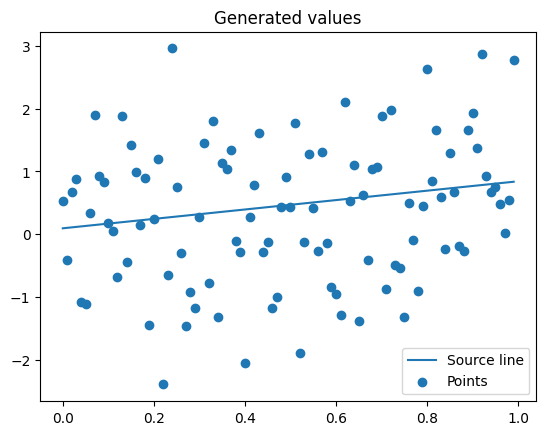

In [5]:
values, x_points, alpha, beta = generate_values()

plt.plot(x_points, [line(x, alpha, beta) for x in x_points], label='Source line')
plt.scatter(x_points, values, label='Points')
plt.title("Generated values")
plt.legend()
plt.show()

## Approximation functions

In [6]:
def loss(point, func, x_points=x_points, y_points=values):
    return np.sum((func(x_points, point[0], point[1]) - y_points) ** 2)

In [7]:
def linear(x, a ,b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

## Algorithms

### Old algo

In [8]:
def neldermead_search(function, args):
    return scipy.optimize.minimize(
        function,
        x0=[0, 0],
        bounds=[(0, 1), (0, 1)],
        method='Nelder-Mead',
        args=args
    )

def exhaustive_search_2(function, args, eps=EPS, x_bounds=(0, 1), y_bounds=(0, 1)):
    return scipy.optimize.brute(
        function,
        ranges=(slice(x_bounds[0], x_bounds[1], eps), (slice(y_bounds[0], y_bounds[1], eps))),
        args=(args, )
    )

def iterations_count(eps=EPS, x_bounds=(0, 1), y_bounds=(0, 1)):
    return ((x_bounds[1] - x_bounds[0]) / eps) * ((y_bounds[1] - y_bounds[0]) / eps)

### First and Second methods

In [31]:
def linear_grad(x, x_points=x_points, y_points=values):
    return np.array(
        [
        np.sum(2 * x_points * (x[0] * x_points + x[1] - y_points)),
        np.sum(2 * x[0] * x_points + 2 * x[1] - 2 * y_points)
    ])

def ratonal_grad(x0, x_points=x_points, y_points=values):
    return np.array([
            np.sum(-(2 * (-x0[0] + x0[1] * x_points * y_points + y_points)) / ((x0[1] * x_points + 1) ** 2)),
            np.sum(-(2 * x0[0] * x_points * (x0[0] - y_points * (x0[1] * x_points + 1))) / ((x0[1] * x_points + 1) ** 3))
        ])

def gradient_descend(x0, function, loss, grad_func, eps=EPS, max_iter=1000):
    iterations_count = 0
    f_calc = 0
    while iterations_count < max_iter:
        iterations_count += 1
        step = - 0.001 * grad_func(x0)
        x0 += step
        f_calc += 2
        if np.all(np.abs(step) < eps):
            break
    return {
        'function': loss(x0, function),
        'f_calc': f_calc,
        'x': x0,
        'iter': iterations_count
    }

In [32]:
def csg_search(function, args):
    return scipy.optimize.minimize(
            function,
            x0=(0, 0),
            method='CG',
            args=(args,)
    )

In [33]:
def newton_search(function, args):
    return scipy.optimize.minimize(
        function,
        x0=(0, 0),
        method='BFGS',
        args=(args,)
    )

In [34]:
def levenberg_loss(point, func):
    return loss(point, func), 0

def levenberg_search(function, args):
    return scipy.optimize.least_squares(
        function,
        x0=(0, 0),
        method='lm',
        args=(args,)
    )

## Linear approximation

In [35]:
brut_points = exhaustive_search_2(loss, linear)
neldermead_points = neldermead_search(loss, linear)

gradient_points = gradient_descend([0, 0], linear, loss, linear_grad)
csg_points = csg_search(loss, linear)
newton_points = newton_search(loss, linear)
levenberg_points = levenberg_search(levenberg_loss, linear)

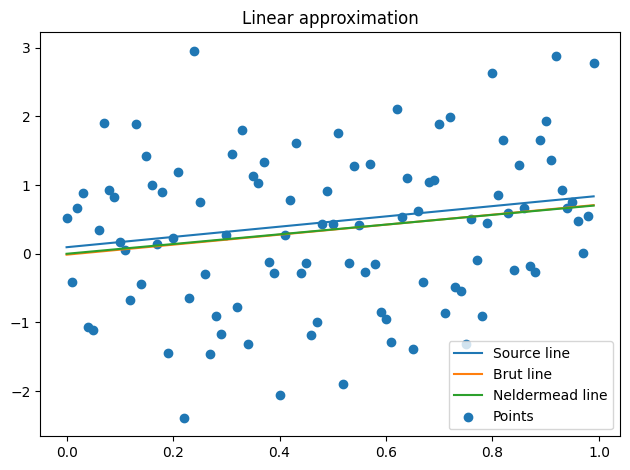

In [36]:
plt.plot(x_points, [line(x, alpha, beta) for x in x_points], label='Source line')
plt.plot(x_points, [line(x, brut_points[0], brut_points[1]) for x in x_points], label='Brut line')
plt.plot(x_points, [line(x, neldermead_points.x[0], neldermead_points.x[1]) for x in x_points], label='Neldermead line')

plt.scatter(x_points, values, label='Points')
plt.title("Linear approximation")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/zero-linear-approximation.png')
plt.show()

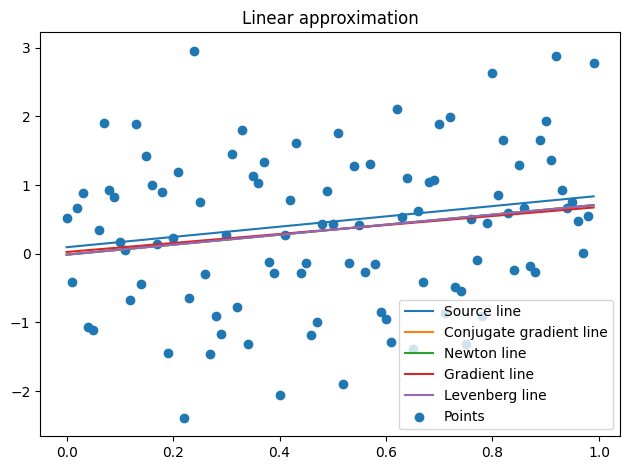

In [37]:

plt.plot(x_points, [line(x, alpha, beta) for x in x_points], label='Source line')
plt.plot(x_points, [line(x, csg_points.x[0], csg_points.x[1]) for x in x_points], label='Conjugate gradient line')
plt.plot(x_points, [line(x, newton_points.x[0], newton_points.x[1]) for x in x_points], label='Newton line')
plt.plot(x_points, [line(x, gradient_points['x'][0], gradient_points['x'][1]) for x in x_points], label='Gradient line')
plt.plot(x_points, [line(x, levenberg_points.x[0], levenberg_points.x[1]) for x in x_points], label='Levenberg line')
plt.scatter(x_points, values, label='Points')
plt.title("Linear approximation")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/linear-approximation.png')
plt.show()

In [38]:
pd.DataFrame(
    columns=['iterations', 'calculations','loss'],
    index=['Brut Force', 'Neldermead', 'Gradient', 'Conjugate gradient', 'Newton', 'Levenberg'],
    data=np.array([
        [iterations_count(), neldermead_points.nit, gradient_points['iter'], csg_points.nit, newton_points.nit, levenberg_points.nfev],
        [iterations_count(), neldermead_points.nfev, gradient_points['f_calc'], csg_points.nfev, newton_points.nfev, levenberg_points.nfev],
        [loss(brut_points, linear), neldermead_points.fun, gradient_points['function'], csg_points.fun, newton_points.fun, levenberg_points.fun[0]]
    ], dtype=object).T
)

,iterations,calculations,loss
Brut Force,1000000.0,1000000.0,123.201497
Neldermead,55,104,123.205948
Gradient,154,308,123.248009
Conjugate gradient,2,15,123.201497
Newton,2,15,123.201497
Levenberg,159,159,123.201498


## Rational approximation

In [39]:
brut_points = exhaustive_search_2(loss, rational)
neldermead_points = neldermead_search(loss, rational)

gradient_points = gradient_descend([0, 0], rational, loss, ratonal_grad)
csg_points = csg_search(loss, rational)
newton_points = newton_search(loss, rational)
levenberg_points = levenberg_search(levenberg_loss, rational)

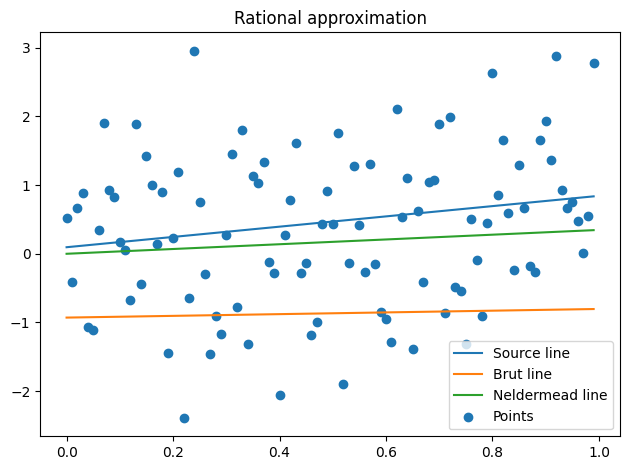

In [40]:
plt.plot(x_points, [line(x, alpha, beta) for x in x_points], label='Source line')
plt.plot(x_points, [line(x, brut_points[0], brut_points[1]) for x in x_points], label='Brut line')
plt.plot(x_points, [line(x, neldermead_points.x[0], neldermead_points.x[1]) for x in x_points], label='Neldermead line')

plt.scatter(x_points, values, label='Points')
plt.title("Rational approximation")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/zero-rational-approximation.png')
plt.show()

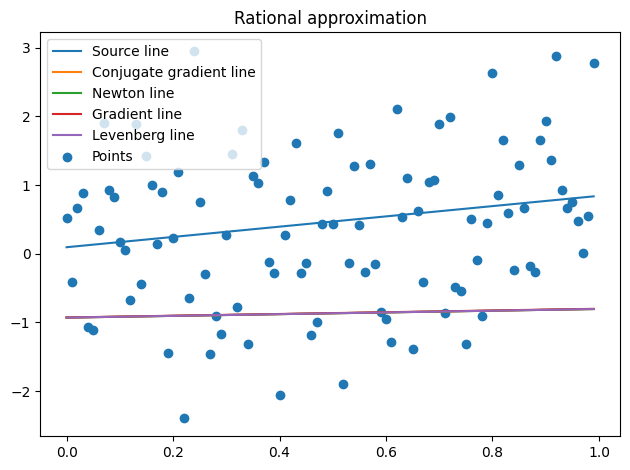

In [41]:

plt.plot(x_points, [line(x, alpha, beta) for x in x_points], label='Source line')
plt.plot(x_points, [line(x, csg_points.x[0], csg_points.x[1]) for x in x_points], label='Conjugate gradient line')
plt.plot(x_points, [line(x, newton_points.x[0], newton_points.x[1]) for x in x_points], label='Newton line')
plt.plot(x_points, [line(x, gradient_points['x'][0], gradient_points['x'][1]) for x in x_points], label='Gradient line')
plt.plot(x_points, [line(x, levenberg_points.x[0], levenberg_points.x[1]) for x in x_points], label='Levenberg line')
plt.scatter(x_points, values, label='Points')
plt.title("Rational approximation")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/rational-approximation.png')
plt.show()

In [42]:
pd.DataFrame(
    columns=['iterations', 'calculations','loss'],
    index=['Brut Force', 'Neldermead', 'Gradient', 'Conjugate gradient', 'Newton', 'Levenberg'],
    data=np.array([
        [iterations_count(), neldermead_points.nit, gradient_points['iter'], csg_points.nit, newton_points.nit, levenberg_points.nfev],
        [iterations_count(), neldermead_points.nfev, gradient_points['f_calc'], csg_points.nfev, newton_points.nfev, levenberg_points.nfev],
        [loss(brut_points, rational), neldermead_points.fun, gradient_points['function'], csg_points.fun, newton_points.fun, levenberg_points.fun[0]]
    ], dtype=object).T
)

,iterations,calculations,loss
Brut Force,1000000.0,1000000.0,118.972927
Neldermead,39,62,127.622963
Gradient,128,256,118.973762
Conjugate gradient,13,195,118.972926
Newton,12,78,118.972926
Levenberg,161,161,118.972927
